# Cálculo de NDVI 

En este notebook se generará la métrica de NDVI. 

NDVI (Normalized Difference Vegetation Index) is a widely used remote sensing index to measure vegetation health, density, and vigor. It works by leveraging the difference in reflectance properties of vegetation in the red and near-infrared (NIR) portions of the electromagnetic spectrum.

Healthy vegetation absorbs most of the red light (used in photosynthesis) and reflects a significant portion of near-infrared light. Unhealthy or sparse vegetation reflects more red light and less near-infrared light.

<div style="text-align: center;">
    <img src="Images/NVDI_formula.png" alt="Descripción de la imagen" width="500">
</div>
 




**IMPORTACION DE LIBRERIAS**

In [2]:
import os 
import ee 
import pandas as pd
import geemap
import requests
import plotly.express as px

## 1) Autentificación 

In [3]:
# 1) Obtención de la dirección de trabajo 
direction = os.getcwd()

# Remove the last part of the path
direction = os.path.dirname(direction)

# Dirección de la llave 
service_account = direction + '/conf/local/gcp-for-data-science-397913-4fd843feede1.json'

# Autentificación 
credentials = ee.ServiceAccountCredentials(email=None, key_file=service_account)
ee.Initialize(credentials)

## 2) Lectura y procesamiento de imagenes  
Las imagenes satelitales se almacenaron en un bucket de GCP, por lo que serán leídas de ahi mismo.

API Reference:
 
  https://developers.google.com/earth-engine/apidocs/ee-image-loadgeotiff

### 2.1) Cálculo y exportación de imagenes con NDVI 

In [6]:
# 1) Lectura del nombre de las imagenes en el bucket 
images_names = pd.read_csv(filepath_or_buffer=direction + "/data/02_intermediate/images_names.csv")

# diccionario de imagenes 
images_dic = {}

# Importación del mapa base 
Map = geemap.Map()

# Path to the image in the GCS bucket
image_center = images_names["Images names"][0]
image_center   = f'gs://earth_engine_selene/sentinel2/{image_center}.tif'
    
# Load the image from the GCS bucket
image = ee.Image.loadGeoTIFF(uri=image_center)

# Central el mapa 
Map.centerObject(ee_object=image, zoom= 9)


# 2) Inicio del ciclo 
for i in images_names["Images names"]:
    
    # 1) Descarga de imagenes 
    # Path to the image in the GCS bucket
    gcs_path = f'gs://earth_engine_selene/sentinel2/{i}.tif'
    
    # Load the image from the GCS bucket
    image = ee.Image.loadGeoTIFF(gcs_path)
     
    # 2) Calculate NDVI (if bands are organized)
    image = image.normalizedDifference(['B8', 'B4']).rename('NDVI')  # Renombre de la banda resultante (capa) 
    print(f"NDVI Calculated for {i}")
    
    # 3) Generaación de URL 
    rgb_bands = ["NDVI"]

    # Determinación de los parámetros para la visualización
    ndvi_vis = {
    "min": 0,
    "max": 1,
    "palette": [ # Usaremos hex code para la determinación de los colores
        "#FF0000",  # Red
        "#FF4500",  # Orange-Red
        "#FFA500",  # Orange
        "#f1f117",  # Yellow
        "#6fe120",  # Soft Green
        "#008000"   # Green
    ],
    "bands": rgb_bands}

    url = image.getThumbURL(ndvi_vis)
    print(f"Thumbnail URL for {i}: {url}")
        
    # 4) Descarga de los datos 
    # Download the image and save it locally
    output_file = direction + f"/data/02_intermediate/NDVI/{i}.png"

    response = requests.get(url=url)
    if response.status_code == 200:
        with open(file=output_file, mode='wb') as f: #string "output_file" para exportar en esa direccion la imagen
            f.write(response.content) # Esto es lo que exportara que es el contenido de la respuesta, la imagen
        print(f"Image successfully downloaded as '{output_file}'")
    else:
        print(f"Error: Unable to download the image. HTTP status code {response.status_code}")
    
    images_dic[i]  = image
    
    # 5) Añadimos la imagen al mapa html 
    Map.addLayer(ee_object=image,  vis_params= ndvi_vis , name=f'NDWI {i}', shown=True)

    # Añadimo una legenda
    Map.add_colorbar(
    ndvi_vis,
    label="NDVI values",
    layer_name="SRTM DEM",
    orientation="vertical",
    transparent_bg=True,
    discrete=False)

# Exportación del HTML 
html_file = direction + "/data/07_model_output/Map_NDVI.html"
Map.to_html(filename=html_file, title="My Map", width="100%", height="880px") # Exporacion a una html 

NDVI Calculated for image_2023-1
Thumbnail URL for image_2023-1: https://earthengine.googleapis.com/v1/projects/earthengine-legacy/thumbnails/17567d3d0aa21d5314e28c75cb856a41-7723c375eeefbd17afb9cccac968883d:getPixels
Image successfully downloaded as '/Users/orlandoandrade/Documents/Negocios/Satelites/selene/data/02_intermediate/NDVI/image_2023-1.png'
NDVI Calculated for image_2023-3
Thumbnail URL for image_2023-3: https://earthengine.googleapis.com/v1/projects/earthengine-legacy/thumbnails/b984af14f69937054be4d12f14cea671-4ee748eb5be397a4a158857de121d4f0:getPixels
Image successfully downloaded as '/Users/orlandoandrade/Documents/Negocios/Satelites/selene/data/02_intermediate/NDVI/image_2023-3.png'
NDVI Calculated for image_2023-5
Thumbnail URL for image_2023-5: https://earthengine.googleapis.com/v1/projects/earthengine-legacy/thumbnails/08f231f98887cf50f43f7f02e6e21ece-02cd4da9c214800a4bceb745e1f6c53a:getPixels
Image successfully downloaded as '/Users/orlandoandrade/Documents/Negocios

In [9]:
Map = geemap.Map()

dem = ee.Image('USGS/SRTMGL1_003')
vis_params = {
    'min': 0,
    'max': 4000,
    'palette': ['006633', 'E5FFCC', '662A00', 'D8D8D8', 'F5F5F5']
}

Map.addLayer(dem, vis_params, 'STRM DEM')

colors = vis_params['palette']
vmin = vis_params['min']
vmax = vis_params['max']

Map.add_colorbar(colors, vmin=vmin, vmax=vmax)

Map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [11]:
# Exportacion de la imgen a PNG , es necesario instalar un paquete adicional llamado mss (pip install mss)
png_file = "/Users/orlandoandrade/Documents/Negocios/Satelites/selene/data/07_model_output/test.png"
Map.to_image(filename=png_file, monitor=1)


PRUEBA CON RASTERIO y MATPLOLIB, 
Encontre que esta es la mejor opcion para mis necesidades, hay que configurar esto de mejor manera y tener un poco más de informacion de  las librerias que se estan utilizando 


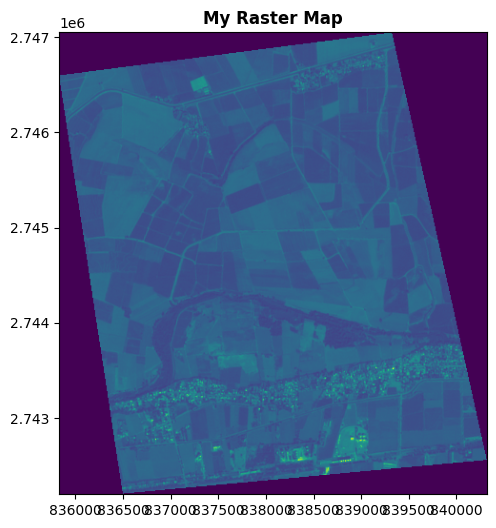

In [12]:
import matplotlib.pyplot as plt
from rasterio.plot import show
import rasterio

tiff_path = "/Users/orlandoandrade/Downloads/sentinel2_image_2023-1.tif"
# Using rasterio's built-in 'show' function
with rasterio.open(tiff_path) as src:
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Plot the raster
    show(src, ax=ax, title="My Raster Map")
    
    # Add a colorbar (the easiest way is to do it manually after imshow)
    # But we can do something like:
    # (If you read data manually, you'd do: im = ax.imshow(data, ...)
    # then fig.colorbar(im, ax=ax) )
    
    plt.show()


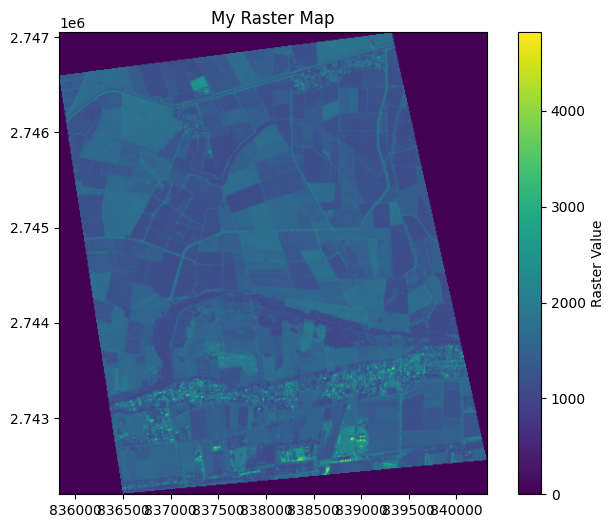

In [13]:
with rasterio.open(tiff_path) as src:
    data = src.read(1)
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Define extent based on the transform
    # left, bottom, right, top = bounds
    extent = (src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top)
    
    # Plot using matplotlib imshow
    im = ax.imshow(data, extent=extent, cmap='viridis', origin='upper')
    
    # Add a title
    ax.set_title("My Raster Map")
    
    # Add a colorbar as the legend of values
    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label("Raster Value")
    
    plt.show()


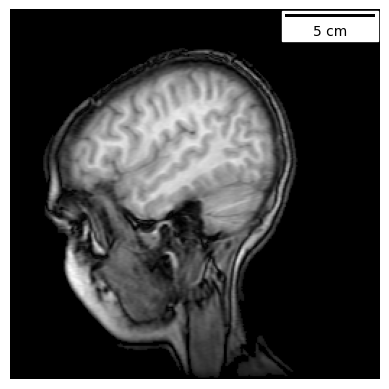

In [14]:
# AÑADIUMOS UNA BARRA DE ESCALA, ejemplo :


import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cbook as cbook
from matplotlib_scalebar.scalebar import ScaleBar

# Load image
with cbook.get_sample_data("s1045.ima.gz") as dfile:
    im = np.frombuffer(dfile.read(), np.uint16).reshape((256, 256))

# Create subplot
fig, ax = plt.subplots()
ax.axis("off")

# Plot image
ax.imshow(im, cmap="gray")

# Create scale bar
scalebar = ScaleBar(0.08, "cm", length_fraction=0.25)
ax.add_artist(scalebar)

# Show
plt.show()


Referencia de como añadir elementos a los mapas:

https://www.youtube.com/watch?v=qiKns09X1Ao

In [ ]:
## PENDIENTE : Establecer rangos de salud y hacer mas bien la visualizacion de manera categorica. 

### 2.2)  NVDI promedio en el tiempo 
Para poder generar un scatter plot de los niveles de NVDI en la imagen a traves del tiempo hay que hacer un calculo de agregación (en este caso un promedio) de los valores de NVDI de los pixeles en cada imagen  y asociarlas

In [5]:
# Obtengo las llaves del diccionario 
keys  =  list(images_dic.keys()) # Recordemos que estas imagenes ya solo contienen la banda (indice de NVDI) calculado 

# Almacenamiento de la media del NVDI 
nvdi_values ={}

for i in keys:
    # Extracción de la imagen 
    ndvi_image = images_dic[i]
    
    # Calculo de la media de NVDI de toda la imagen 
    # Calculate mean using reduceRegion
    mean = ndvi_image.reduceRegion(
        reducer=ee.Reducer.mean(),
        scale=10,  # Pixel resolution (meters)
        maxPixels=1e9 # Esto es importante, es el número maximo de pixeles que se usarán para el cálculo 
    )
    # Esto es un ee diccionary 
    # The result is a earth engine diccionary, it is neccesary. In order to do this is neccesary to use the function get info()
    mean = mean.getInfo() # This returns a python dictionary
    
    # Almacenamiento de los resultados 
    nvdi_values[i] = mean["NDVI"] # Esta es la llave del diccionario

**RESULTADOS EN UN PANDAS DF**

In [7]:
# Convertimos los resultados a un pandas DF 
ndvi_mean_data = pd.DataFrame(list(nvdi_values.items()), columns =["Date", "NDVI"])
ndvi_mean_data

,Date,NDVI
0,image_2023-1,0.245787
1,image_2023-3,0.358347
2,image_2023-5,0.261947
3,image_2023-7,0.117241
4,image_2023-9,0.143728
5,image_2023-10,0.167872
6,image_2023-11,0.123687


**VISUALIZACION EN EL TIEMPO**

In [14]:
# Crear el gráfico con Plotly
fig = px.line(
    data_frame=ndvi_mean_data, x='Date', y='NDVI',
    markers=True,
    title='NDVI Over Time',
    labels={'Date': 'Date', 'NDVI': 'NDVI Value'}
)

# Mostrar el gráfico
#fig.show()

## 3) Post procesamiento
En esta sección lo que se busca es tomar las imagenes prviamente generadas y darles un mejor formato. Integrando título, escala y una leyenda con los valores de los colores

In [ ]:
### AQUI VOY !!, las imagenes están en el diccioanrio image_dic

In [10]:
import geemap
import folium
import os

# Define file paths
image_path = direction + "/data/02_model_intermediate/NDVI/image_2023-1.png"
output_html = direction + "/data/08_reporting/NDVI_Map_with_Legend.html"

# Initialize the map
Map = geemap.Map(center=[37.5, -122.5], zoom=10)  # Adjust to your region
Map.add_basemap("SATELLITE")  # Add a satellite basemap

# Overlay the NDVI image
Map.add_image(image_path, position="bottomleft")

# Create a legend for NDVI
legend_dict = {
    "Low Vegetation (0-0.2)": "#FF0000",
    "Moderate Vegetation (0.2-0.4)": "#FF4500",
    "Healthy Vegetation (0.4-0.6)": "#FFA500",
    "Very Healthy (0.6-0.8)": "#FFFF00",
    "Dense Vegetation (0.8-1)": "#008000",
}

Map.add_legend(legend_title="NDVI Index", legend_dict=legend_dict)

# Add a title and a scale bar
title_html = '''
 <h3 align="center" style="font-size:20px"><b>NDVI Analysis - January 2023</b></h3>
'''
#Map.get_root().html.add_child(folium.Element(title_html))
#Map.add_child(folium.plugins.ScaleBar(position="bottomright"))

# Export the map to HTML
Map.to_html(filename=output_html, title="NDVI Map with Legend and Scale")


## 4) Exportación
Se exportará los resultados finales

In [13]:
# Exportación de tabla promedio del NVDI del área de interes
ndvi_mean_data.to_csv(path_or_buf=direction + "/data/07_model_output/NDVI/Medias_NDVI.csv", index=False)

# Exportación del grafico
fig.write_html(direction +"/data/07_model_output/NDVI/NDVI_time.html")

In [8]:
direction

'/Users/orlandoandrade/Documents/Negocios/Satelites/selene'